# Importing Necesseties 

In [1]:
import re
import string
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch


# Reading the Data

In [2]:
train = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/train.csv')
test = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/test.csv')
sample_submission = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/sample_submission.csv')

In [3]:
train

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [4]:
print(train.shape)
print(test.shape)

(27481, 4)
(3534, 3)


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
textID           27481 non-null object
text             27480 non-null object
selected_text    27480 non-null object
sentiment        27481 non-null object
dtypes: object(4)
memory usage: 858.9+ KB


In [13]:
train.dropna(inplace=True)

In [16]:
test.info()

(27480, 5)


In [7]:
def jaccard (text1, text2):
    a = set(text1.split())
    b = set(text2.split())
    intresection = a.intersection(b)
    IOU =(float) (len(intresection))/(len(a)+len(b)-len(intresection))
    return IOU

In [8]:
jaccard_list=[]
def calc_jaccard():
    for row in train.itertuples():
        jaccard_list.append(jaccard (row.text, row.selected_text))
    return jaccard_list;

In [9]:
jac = calc_jaccard()


In [10]:
train['jaccard'] = jac

In [11]:
train

,textID,text,selected_text,sentiment,jaccard
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.000000
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.200000
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0.214286
...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,0.058824
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,0.083333
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,0.272727
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,1.000000


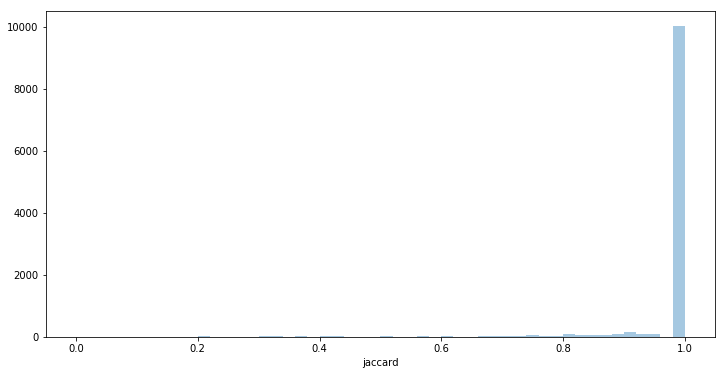

In [12]:
plt.figure(figsize=(12,6))
sns.distplot(train[train['sentiment']=='neutral']['jaccard'],kde=False)

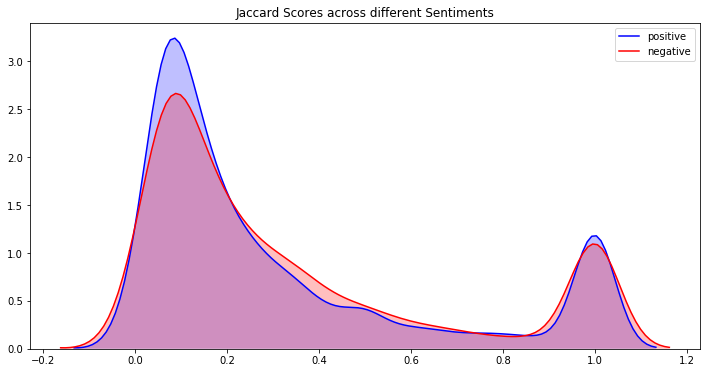

In [17]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train[train['sentiment']=='positive']['jaccard'], shade=True, color="b").set_title('Jaccard Scores across different Sentiments')
p2=sns.kdeplot(train[train['sentiment']=='negative']['jaccard'], shade=True, color="r")
plt.legend(labels=['positive','negative'])

In [18]:
train['no_words'] = train['text'].apply(lambda x:len(str(x).split()))

In [19]:
lessThanThree = train[train['no_words']<=2]

In [20]:
lessThanThree.groupby('sentiment').mean()['jaccard']

sentiment
negative    0.788580
neutral     0.977805
positive    0.765700
Name: jaccard, dtype: float64

In [21]:
lessThanThree[lessThanThree['sentiment']=='negative']

,textID,text,selected_text,sentiment,jaccard,no_words
26,852edc3769,I`m sorry.,I`m sorry.,negative,1.0,2
124,f0460d611d,not well,not well,negative,1.0,2
144,7e4ed52c4a,Hate fighting,Hate fighting,negative,1.0,2
218,a8734230b6,Ew traffic,Ew traffic,negative,1.0,2
329,0404648e1c,?sucks!?..,?sucks!?..,negative,1.0,1
...,...,...,...,...,...,...
26260,cfedf94a53,"ohh, ouch",ouch,negative,0.5,2
26754,b6f6bd82c0,careless,careless,negative,1.0,1
26798,0e2f13043e,reaaaallly bored,reaaaallly bored,negative,1.0,2
26851,b732cd6641,I`m sorry,I`m sorry,negative,1.0,2


In [25]:
df_train = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/train.csv')
df_test = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/test.csv')
df_submission = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/sample_submission.csv')
df_train

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [26]:
df_train['no_words'] = df_train['text'].apply(lambda x:len(str(x).split()))
df_train = df_train[df_train['no_words']>=3]

In [24]:
df_train

,textID,text,selected_text,sentiment,no_words
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,7
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,10
2,088c60f138,my boss is bullying me...,bullying me,negative,5
3,9642c003ef,what interview! leave me alone,leave me alone,negative,5
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,14
...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,16
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,23
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,22
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,6


In [ ]:
def get_training_data(sentiment):
   
    train_data = []
    for row in df_train.itertuples():
        if row.sentiment == sentiment:
            selected_text = row.selected_text
            text = row.text
            start = text.find(selected_text)
            end = start + len(selected_text)
            train_data.append((text, {"entities": [[start, end, 'selected_text']]}))
    return train_data

In [ ]:
def get_model_out_path(sentiment):
    '''
    Returns Model output path
    '''
    model_out_path = None
    if sentiment == 'positive':
        model_out_path = 'models/model_pos'
    elif sentiment == 'negative':
        model_out_path = 'models/model_neg'
    return model_out_path

In [ ]:
def save_model(output_dir, nlp):
    ''' This Function Saves model to 
    given output directory'''
    
    output_dir = f'../working/{output_dir}'
    if output_dir is not None:        
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        nlp.to_disk(output_dir)
        print("Saved model to", output_dir)

In [ ]:
def train_model(train_data, output_dir, n_iter=20):
 
    nlp = spacy.blank("en")  # create blank Language class
    
    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    ner = nlp.create_pipe("ner")
    nlp.add_pipe(ner, last=True)
    
    # add labels
    ner.add_label('selected_text')

    nlp.begin_training()


    for itn in tqdm(range(n_iter)):
        random.shuffle(train_data)
        batches = minibatch(train_data, size=compounding(4.0, 500.0, 1.001))    
        losses = {}
        for batch in batches:
            texts, annotations = zip(*batch)
            nlp.update(texts,  
                        annotations,  
                        drop=0.5,   
                        losses=losses, 
                        )
        print("Losses", losses)
    save_model(output_dir, nlp)

#### Training models for Positive and Negative tweets

In [ ]:
sentiment = 'positive'

train_data = get_training_data(sentiment)
model_path = get_model_out_path(sentiment)
train_model(train_data, model_path, n_iter=40)

In [ ]:
sentiment = 'negative'  
 
train_data = get_training_data(sentiment)  
model_path = get_model_out_path(sentiment) 

train_model(train_data, model_path, n_iter=40) 

In [ ]:
def predict_entities(text, model):  
    doc = model(text)
    ent_array = []
    for ent in doc.ents:
        start = text.find(ent.text)
        end = start + len(ent.text)
        new_int = [start, end, ent.label_] 
        if new_int not in ent_array:
            ent_array.append([start, end, ent.label_])
    selected_text = text[ent_array[0][0]: ent_array[0][1]] if len(ent_array) > 0 else text
    return selected_text

In [ ]:
selected_texts = []
MODELS_BASE_PATH = './models/'

if MODELS_BASE_PATH is not None:
    print("Loading Models  from ", MODELS_BASE_PATH)
    model_pos = spacy.load(MODELS_BASE_PATH + 'model_pos')
    model_neg = spacy.load(MODELS_BASE_PATH + 'model_neg')
        
    for index, row in df_test.iterrows():
        text = row.text
        output_str = ""
        if row.sentiment == 'neutral' or len(text.split()) <= 2:
            selected_texts.append(text)
        elif row.sentiment == 'positive':
            selected_texts.append(predict_entities(text, model_pos))
        else:
            selected_texts.append(predict_entities(text, model_neg))
        
df_test['selected_text'] = selected_texts

In [ ]:
df_submission['selected_text'] = df_test['selected_text']
df_submission.to_csv("submission.csv", index=False)
display(df_submission.head(10))